# Performing classification analysis on Wisconsin breast cancer data set using neural networks

In this notebook we will train a neural network on the Wisconsin breast cancer data set and TODO

First, we are looking to uncover which modes and regularization parameters to use in our neural network:

In [24]:
import numpy as np
import matplotlib.pyplot as plt

from feedforward_nn import NeuralNetwork
from gradient_descent import GradientDescent
from regression_tools import accuracy

from sklearn.datasets import load_breast_cancer as wbc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

ImportError: cannot import name 'accuracy' from 'regression_tools' (c:\Users\leand\FYS-STK\FYS-STK3155-project-2\regression_tools.py)

In [12]:
# Load data
data = wbc()
X = data.data
y = data.target

# Split data into training and test sets
X_train, X_test, z_train, z_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, z_train, z_val = train_test_split(X_train, z_train, test_size=0.2)
n = X_train.shape[1]

# Use minimax to scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


In [13]:
def optimal_reg_neural_network(X_train, 
                               z_train, 
                               X_val, 
                               z_val, 
                               layers, 
                               regularizationrange, 
                               momentum=0,
                               avg_num = 10,
                               optmode="normal", 
                               max_iter=200, 
                               eta=0.01,
                               activation="sigmoid",
                               output_activation="sigmoid",
                               ):
    """Returns the optimal regularization parameter for a neural network with the given parameters, taking the average over avg_num runs."""
    accuracy_val = []
    for reg in regularizationrange:
        # Average over avg_num runs
        acc = 0
        for _ in range(avg_num):
            nn = NeuralNetwork(layers, activation=activation, output_activation=output_activation, regularization=reg)
            w0 = nn.wb()
            batch_size = 16
            store_extra = True

            gd = GradientDescent(batch_size=batch_size, momentum_param=momentum, store_extra=store_extra, mode=optmode)
            w = gd.train(X_train, w0, z_train, nn, eta, max_iter)
            z_pred = np.around(nn.predict(X_val, w).flatten())
            acc += accuracy(z_pred, z_val)
        acc /= avg_num
        accuracy_val.append(acc)
    # Return best regularization parameter, corresponding accuracy and accuracy_val
    return regularizationrange[np.argmax(accuracy_val)], np.max(accuracy_val), accuracy_val
    

In [95]:
# Perform grid search on regularization for each activation function
activations = ["linear", "sigmoid", "relu", "leaky_relu"]
best_lam = []
best_acc = []
accuracy_val = []
for activation in activations:
    print(f"Activation: {activation}")
    lambdas = np.logspace(-6, 3, 10)
    best_lam_mode, best_acc_mode, accuracy_val_mode = optimal_reg_neural_network(X_train, z_train, X_val, z_val, [n, 20, 10, 1], lambdas, optmode="normal", avg_num=30, max_iter=100, eta=0.01, activation=activation)
    best_lam.append(best_lam_mode)
    best_acc.append(best_acc_mode)
    accuracy_val.append(accuracy_val_mode)


Activation: linear
Activation: sigmoid
Activation: relu
Activation: leaky_relu


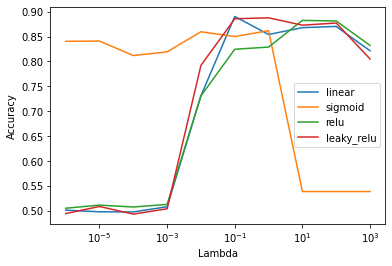

In [96]:
# Plot accuracy vs. regularization parameter for each activation function
for i in range(len(activations)):
    plt.semilogx(lambdas, accuracy_val[i], label=activations[i])
    plt.xlabel("Lambda")
    plt.ylabel("Accuracy")
    plt.legend()
plt.show()



In [66]:

# Grid search on regularization parameter for each mode - low resolution, as we only want to find the best mode
modes = ["normal", "adagrad", "rmsprop", "adam"]
best_lam = []
best_acc = []
accuracy_val = []
for mode in modes:
    print(f"Mode: {mode}")
    lambdas = np.logspace(-10, 0, 10)
    # TODO: Fix adagrad
    if mode=="adagrad":
        best_lam_mode, best_acc_mode, accuracy_val_mode = optimal_reg_neural_network(X_train, z_train, X_val, z_val, [n, 20, 10, 1], lambdas, momentum=0.8, optmode=mode, avg_num=40, max_iter=80, eta=10)
    else:
        best_lam_mode, best_acc_mode, accuracy_val_mode = optimal_reg_neural_network(X_train, z_train, X_val, z_val, [n, 20, 10, 1], lambdas, optmode=mode, avg_num=40, max_iter=80, eta=0.01)
    best_lam.append(best_lam_mode)
    best_acc.append(best_acc_mode)
    accuracy_val.append(accuracy_val_mode)


Mode: normal


c:\Users\leand\FYS-STK\FYS-STK3155-project-2\feedforward_nn.py:70: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Mode: adagrad


c:\Users\leand\FYS-STK\FYS-STK3155-project-2\gradient_descent.py:138: RuntimeWarning: divide by zero encountered in true_divide
  return self.eta / np.sqrt(self.G)
c:\Users\leand\FYS-STK\FYS-STK3155-project-2\gradient_descent.py:108: RuntimeWarning: invalid value encountered in multiply
  return self.momentum * self.momentum_param - eta * model.gradient(X, w, y)


Mode: rmsprop
Mode: adam


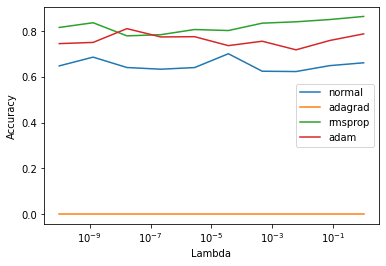

Mode	Best lambda	Accuracy
normal	3.59e-05	0.70
adagrad	1.00e-10	0.00
rmsprop	1.00e+00	0.86
adam	1.67e-08	0.81


In [67]:
# Plot accuracy vs. regularization parameter for each mode
for i in range(len(modes)):
    plt.semilogx(lambdas, accuracy_val[i], label=modes[i])
    plt.xlabel("Lambda")
    plt.ylabel("Accuracy")
    plt.legend()
plt.show()

# Print best regularization parameter for each mode as a table
print("Mode\tBest lambda\tAccuracy")
for i in range(len(modes)):
    print(f"{modes[i]}\t{best_lam[i]:.2e}\t{best_acc[i]:.2f}")

We see that rmsprop consistently outperforms the other modes, and choose this mode in our further analysis.

We now want to explore different activation functions for hidden layers.

Shocking. We see that sigmoid does better for most regularization parameters, until this parameter reaches high enough values. It appears linear og leaky_relu performs better here. We thus choose leaky_relu in our further analysis, and note that the regularization range we here need to consider seems to be from around 1e-2 to 1e3

In [100]:
def optimal_lr_neural_network(X_train,
                              z_train,
                              X_val,
                              z_val,
                              layers,
                              regularization,
                              lrrange,
                              momentum=0,
                              avg_num=10,
                              optmode="normal",
                              max_iter=200,
                              activation="sigmoid",
                              output_activation="sigmoid",
                              eta=0.01
                              ):
    """Returns the optimal learning rate for a neural network with the given parameters, taking the average over avg_num runs."""
    accuracy_val = []
    for lr in lrrange:
        # Average over avg_num runs
        acc = 0
        for _ in range(avg_num):
            nn = NeuralNetwork(layers, activation=activation, output_activation=output_activation, regularization=regularization)
            w0 = nn.wb()
            batch_size = 16
            store_extra = True

            gd = GradientDescent(batch_size=batch_size, momentum_param=momentum, store_extra=store_extra, mode=optmode)
            w = gd.train(X_train, w0, z_train, nn, lr, max_iter)
            z_pred = np.around(nn.predict(X_val, w).flatten())
            acc += accuracy(z_pred, z_val)
        acc /= avg_num
        accuracy_val.append(acc)
    # Return best learning rate, corresponding accuracy and accuracy_val
    return lrrange[np.argmax(accuracy_val)], np.max(accuracy_val), accuracy_val

In [102]:
# Perform grid search on learning rate for rmsprop
# TODO: Must be done for much higher iterations
lrrange = np.logspace(-5, 0, 10)
best_lr, best_acc, accuracy_val = optimal_lr_neural_network(X_train, z_train, X_val, z_val, [n, 20, 10, 1], 1, lrrange, optmode="rmsprop", avg_num=40, max_iter=80, eta=0.01, activation="leaky_relu")


c:\Users\leand\FYS-STK\FYS-STK3155-project-2\feedforward_nn.py:70: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


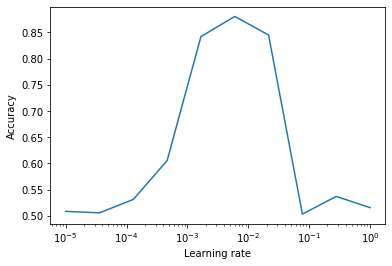

Best learning rate: 5.99e-03


In [103]:
# Plot accuracy vs. learning rate for rmsprop
plt.semilogx(lrrange, accuracy_val)
plt.xlabel("Learning rate")
plt.ylabel("Accuracy")
plt.show()

# Print best learning rate for rmsprop
print(f"Best learning rate: {best_lr:.2e}")

We see that the optimal accuracy is reached with a learning rate of around 0.006, and will use this going forward.

We will now find the optimal regularization parameter, with these previous parameters, for different neural network structures - that is, different amounts of layers, and different amounts of nodes in these layers.

In [15]:
nn_structures = [
    [n, 20, 15, 10, 5, 1],
    [n, 20, 10, 1],
    [n, 5, 4, 3, 2, 1],
    [n, 10, 5, 1]
]

nn_best_lambda = []
nn_best_acc = []
nn_accuracy_vals = []

# Perform grid search on regulariszation for rmsprop with leaky relu, learning rate 0.006 and regularization between 0.01 and 1000
lambdas = np.logspace(-2, 3, 25)
for nn in nn_structures:
    print(f"Neural network structure: {nn}")
    best_lam, best_acc, accuracy_val = optimal_reg_neural_network(X_train, z_train, X_val, z_val, nn, lambdas, optmode="rmsprop", avg_num=30, max_iter=100, eta=0.006, activation="leaky_relu")
    nn_best_lambda.append(best_lam)
    nn_best_acc.append(best_acc)
    nn_accuracy_vals.append(accuracy_val)
    # Save to file notebooks/NNcancer_gridsearch.txt
    with open("notebooks/NNcancer_gridsearch.txt", "a") as f:
        # Add space
        f.write("\n\n")
        f.write(f"Neural network structure: {nn}\n")
        f.write(f"Lamdas: {lambdas}\n")
        f.write(f"Best lambda: {best_lam}\n")
        f.write(f"Best accuracy: {best_acc}\n")
        f.write(f"Accuracy values: {accuracy_val}\n\n")


Neural network structure: [30, 20, 15, 10, 5, 1]


c:\Users\leand\FYS-STK\FYS-STK3155-project-2\feedforward_nn.py:70: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Neural network structure: [30, 20, 10, 1]
Neural network structure: [30, 5, 4, 3, 2, 1]
Neural network structure: [30, 10, 5, 1]


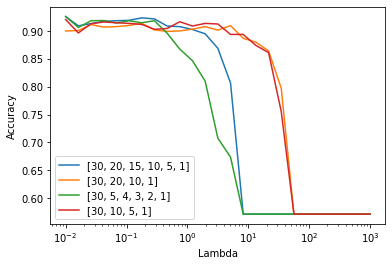

In [16]:
# Plot accuracy vs. regularization parameter for each neural network structure
for i in range(len(nn_structures)):
    plt.semilogx(lambdas, nn_accuracy_vals[i], label=nn_structures[i])
    plt.xlabel("Lambda")
    plt.ylabel("Accuracy")
    plt.legend()
plt.show()

In [17]:
# Print best regularization parameter for each neural network structure as a table
print("Neural network structure\tBest lambda\tAccuracy")
for i in range(len(nn_structures)):
    print(f"{nn_structures[i]}\t{nn_best_lambda[i]:.2e}\t{nn_best_acc[i]:.2f}")


Neural network structure	Best lambda	Accuracy
[30, 20, 15, 10, 5, 1]	1.00e-02	0.93
[30, 20, 10, 1]	1.78e-01	0.91
[30, 5, 4, 3, 2, 1]	1.00e-02	0.93
[30, 10, 5, 1]	1.00e-02	0.92


In [20]:
# Find best model by applying the previous results to the test set
acc_arr = []
for reg, nn_struc in zip(nn_best_lambda, nn_structures):
    # Average accuracy over 30 runs
    acc = 0
    for _ in range(30):
        nn = NeuralNetwork(nn_struc, activation="leaky_relu", output_activation="sigmoid", regularization=reg)
        w0 = nn.wb()
        batch_size = 16
        store_extra = True

        gd = GradientDescent(batch_size=batch_size, momentum_param=0, store_extra=store_extra, mode="rmsprop")
        w = gd.train(X_train, w0, z_train, nn, 0.006, 100)
        z_pred = np.around(nn.predict(X_test, w).flatten())
        acc += accuracy(z_pred, z_test)
    acc /= 30
    acc_arr.append(acc)

# Print best model
print(f"Best model: {nn_structures[np.argmax(acc_arr)]}")
print(f"Accuracy: {np.max(acc_arr)}")

Best model: [30, 5, 4, 3, 2, 1]
Accuracy: 0.8804093567251462


### Comparison with Scikit-learn

We will now compare our results with those we get with sklearn.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train logistic regression model
lr = LogisticRegression()
lr.fit(X_train, z_train)

# Predict on test set
z_pred = lr.predict(X_test)

# Print accuracy
print(f"Accuracy: {accuracy_score(z_test, z_pred)}")


Accuracy: 0.9210526315789473


c:\Users\leand\AppData\Local\Programs\Python\Python38-32\lib\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
